### [WUR GRS-51806 Geoscripting](https://geoscripting-wur.github.io/)<img src='http://www.wageningenur.nl/upload/f9a0b5f2-15c5-4b84-9e14-20ef02f5e265_wur-logo.png' align="right">
# Week 3 (Python), Lesson 2: Raster handling with Python

## Python modules for raster data handling

The modules used below are:

* ***`gdal`, bindings to the GDAL library *** which is part of the osgeo library
* `numpy` for array calculations.

These two libraries are the base of all raster processing in python!

There are additional libraries that offer wrapper functions for `gdal` and provide additional raster procssesing: functionality:
* mapbox [`rasterio`](https://github.com/mapbox/rasterio), see a [NDVI tutorial](http://www.loicdutrieux.com/pyLandsat/NDVI_calc.html)
* [`rios`](http://rioshome.org/), a set of Python modules which makes it easy to write raster processing code in Python

Many important processing methods are availbale through additional libraries:
* python interface for Orfeo toolbox (`otb`), e.g. segmentation
* `rsgislib` e.g. segmentation
* `scikit-image` for image interpretation
* `scikit-learn` for machine learning

## Data

In the below example we will use a Aster image which you can download from the following [dropbox](https://www.dropbox.com/s/rsc4lzkd3t2adq5/ospy_data5.zip?dl=0). The data is also available [here](http://www.gis.usu.edu/~chrisg/python/2009/lectures/). 

## Reading, deriving NDVI, and writing raster data

Let's get started and we will go through the following steps:

* Open the Aster image (*img format)
* Read in the image data as an array
* Derive the NDVI using array calculations
* Write the resulting file as a (*.tif i.e. Geotif file)
* Close all files

In [4]:
# import modules
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import numpy as np

# open file and print info about the file
# the ¨../¨ refers to the parent directory of my working directory
filename = '../data/ospy_data5/aster.img'
dataSource = gdal.Open(filename, GA_ReadOnly)

print "\nInformation about " + filename 
print "Driver: ", dataSource.GetDriver().ShortName,"/", \
      dataSource.GetDriver().LongName
print "Size is ",dataSource.RasterXSize,"x",dataSource.RasterYSize, \
      'x',dataSource.RasterCount

print '\nProjection is: ', dataSource.GetProjection()

print "\nInformation about the location of the image and the pixel size:"
geotransform = dataSource.GetGeoTransform()
if not geotransform is None:
    print 'Origin = (',geotransform[0], ',',geotransform[3],')'
    print 'Pixel Size = (',geotransform[1], ',',geotransform[5],')'



Information about ../data/ospy_data5/aster.img
Driver:  HFA / Erdas Imagine Images (.img)
Size is  5665 x 5033 x 3

Projection is:  PROJCS["UTM Zone 12, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9108"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1],AUTHORITY["EPSG","32612"]]

Information about the location of the image and the pixel size:
Origin = ( 419976.5 , 4662422.5 )
Pixel Size = ( 15.0 , -15.0 )


In [5]:
# Read data into an array
band2Arr = dataSource.GetRasterBand(2).ReadAsArray(0,0,dataSource.RasterXSize, dataSource.RasterYSize)
band3Arr = dataSource.GetRasterBand(3).ReadAsArray(0,0,dataSource.RasterXSize, dataSource.RasterYSize)
print type(band2Arr)
                                                   

# set the data type
band2Arr=band2Arr.astype(np.float32)
band3Arr=band3Arr.astype(np.float32)

# Derive the NDVI
mask = np.greater(band3Arr+band2Arr,0)

# set np.errstate to avoid warning of invalid values (i.e. NaN values) in the divide 
with np.errstate(invalid='ignore'):
    ndvi = np.choose(mask,(-99,(band3Arr-band2Arr)/(band3Arr+band2Arr)))
print "NDVI min and max values", ndvi.min(), ndvi.max()
# Check the real minimum value
print ndvi[ndvi>-99].min()

<type 'numpy.ndarray'>
NDVI min and max values -99.0 1.0
-1.0


In [6]:
# Write the result to disk
driver = gdal.GetDriverByName('GTiff')
outDataSet=driver.Create('../data/ndvi.tif', dataSource.RasterXSize, dataSource.RasterYSize, 1, GDT_Float32)
outBand = outDataSet.GetRasterBand(1)
outBand.WriteArray(ndvi,0,0)
outBand.SetNoDataValue(-99)

# set the projection and extent information of the dataset
outDataSet.SetProjection(dataSource.GetProjection())
outDataSet.SetGeoTransform(dataSource.GetGeoTransform())


# Finally let's save it... or like in the OGR example flush it
outBand.FlushCache()
outDataSet.FlushCache()

Let's check the resulting file via the *Terminal* (All command in the current document with a **!** in front mean that it is ran via the Shell Terminal. Below we call the `gdalinfo` command of the **GDAL** C++ library directly. If you want to learn more about `gdalinfo` go to: http://www.gdal.org/gdalinfo.html

In [7]:
!gdalinfo ../data/ndvi.tif

Driver: GTiff/GeoTIFF
Files: ../data/ndvi.tif
Size is 5665, 5033
Coordinate System is:
PROJCS["WGS 84 / UTM zone 12N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-111],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","32612"]]
Origin = (419976.500000000000000,4662422.500000000000000)
Pixel Size = (15.000000000000000,-15.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  419976.500, 4662422.500) (111d58' 4.52"W, 42d 6'35.3

Important here is that the `gdalinfo` contains information about the projection  (via `SetProjection`) and also about the corner coordinates (via `SetGeoTransform`)

## Reproject the NDVI image to Lat/long

Reprojecting a raster image can be done by

* calling the `gdalwarp` function of the **GDAL C++** library directly
* using `Python` and the `gdal` module

### Using `gdalwarp`

The easiest way to reproject a raster file is to use GDAL's [gdalwarp](http://www.gdal.org/gdalwarp.html) tool. As an example, we will reproject the above NDVI image derived earlier into latitude/longitude (WGS84).

* -t_srs "EPSG:4326" is the **to** projection, i.e. lat/long, know by its [EPSG code](http://spatialreference.org/ref/epsg/4326/). The **from** projection is already specified in the source data set, see above
* data/ndvi.tif is the **input** dataset
* data/ndvi_ll.tif is the **output** dataset (the output format is here automatically set by the extension i.e. Geotif)

**Question**: what is the **from** projection?

In [ ]:
# via the Shell
!gdalwarp -t_srs "EPSG:4326" ../data/ndvi.tif ../data/ndvi_ll.tif

In [ ]:
# Let's check what the result is
!gdalinfo ../data/ndvi_ll.tif

### Visualise the result

Let's see what the output to the reprojected NDVI image.

In [8]:
# notebook magic to select the plotting method
# change to inline to plot within this notebook
#%matplotlib inline 
%matplotlib inline
from osgeo import gdal
import matplotlib.pyplot as plt

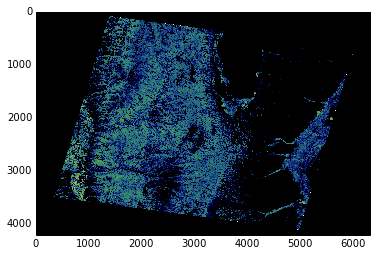

In [3]:
# Open image
dsll = gdal.Open("../data/ndvi_ll.tif")

# Read raster data
ndvi = dsll.ReadAsArray(0, 0, dsll.RasterXSize, dsll.RasterYSize)

# Now plot the raster data using gist_earth palette
plt.imshow(ndvi, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth)
plt.show()

dsll = None

## Execise: Using Python bindings to reproject

With Python, the reprojection is not as straight forward. 
- Create a pyhon script that transforms the NDVI image to EPSG:4326 and saves it! 
- Post your code or github link in the code review forum!

Some links to get started: 
- look the function defined by Prof. P. Lewis (see here [for more information](http://nbviewer.ipython.org/github/profLewis/geogg122/blob/master/Chapter4_GDAL/GDAL_Python_bindings.ipynb)). 
- For core GDALDataset Class reference info (see [GeoTransFrom Info](http://www.gdal.org/classGDALDataset.html#a0fe0f81d65d84557b5d71ddc024faa02). For a relevant question and example on gis stack exchange ([see](https://gis.stackexchange.com/questions/24055/raster-data-array-output-flipped-on-x-axis-using-python-gdal)).
- [GIS StackExchange](https://gis.stackexchange.com/questions/6669/converting-projected-geotiff-to-wgs84-with-gdal-and-python).
- Or use other raster libraries, e.g. [rasterio](https://github.com/mapbox/rasterio/blob/master/examples/reproject.py)


## Additional Resources
- Chris Holden from Boston University on [handling raster data with GDAL](http://www.gis.usu.edu/~chrisg/python/2009/)
- [Blog about Python for GeoSpatial data analysis](http://www.digital-geography.com/python-for-geospatial-data-analysis-part-ii/?subscribe=invalid_email#477)
- https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
- Great basic tutorial: http://www.gdal.org/gdal_tutorial.html
- [GDAL Python info and bindings](http://gdal.org/python/osgeo.gdal_array-module.html#BandReadAsArray)
- yet another example https://borealperspectives.wordpress.com/2014/01/16/data-type-mapping-when-using-pythongdal-to-write-numpy-arrays-to-geotiff/

